In [1]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

This script assumes that it lives in a folder with these two files in it.
- Responses3.xlsx: Myriam's monster spreadsheet with all the participants' data
- Randomization.xlsx: spreadsheet with the randomization list

In [2]:
datafileloc = './ID/Responses3.xlsx'
randomfileloc = './ID/Randomization.xlsx'

First we'll generate a list of the repetitions.  We note that the randomization file has two columns, without names, that represent the item number (presentation order) and stimulus file. 
Since the stimulus file is coded for the series, burst, and step value, we can go ahead and reconstruct that here.

In [3]:
reps = pd.ExcelFile(randomfileloc).parse('Full_Randomization', header=None, names=['item','stimulus'])
# set new variables SERIES, BURST, and STEP based on the values in STIMULUS
reps['series'] = pd.DataFrame(reps.stimulus.str.split('.').tolist())[0]
reps['burst'] = pd.DataFrame(reps.stimulus.str.split('.').tolist())[1]
reps['step'] = pd.DataFrame(reps.stimulus.str.split('.').tolist())[2]
reps.head()

,item,stimulus,series,burst,step
0,1,4.1.7.wav,4,1,7
1,2,1.2.4.wav,1,2,4
2,3,3.2.5.wav,3,2,5
3,4,4.2.7.wav,4,2,7
4,5,4.2.5.wav,4,2,5


In [4]:
def getprop(series, step):
    
    if series==5:
        return 1
    elif series in [1,3]:
        if step==1:
            return 0
        if step==2:
            return .12
        if step==3:
            return .4
        if step==4:
            return .69
        if step==5:
            return 1
    else:
        if step==1:
            return 0
        if step==2:
            return .16
        if step==3:
            return .32
        if step==4:
            return .50
        if step==5:
            return .65
        if step==6:
            return .81
        if step==7:
            return 1

reps['prop_N'] = reps.apply(lambda x: getprop(int(x['series']), int(x['step'])), axis=1)
reps.head()

,item,stimulus,series,burst,step,prop_N
0,1,4.1.7.wav,4,1,7,1.00
1,2,1.2.4.wav,1,2,4,0.69
2,3,3.2.5.wav,3,2,5,1.00
3,4,4.2.7.wav,4,2,7,1.00
4,5,4.2.5.wav,4,2,5,0.65


Because the data file has each participant in its own sheet, we'll do a little extra here to read the data in.

In [5]:
# reads the data in datafileloc as a special pandas ExcelFile object
xl = pd.ExcelFile(datafileloc)
subjects = xl.sheet_names  # since the sheets are named by their subject, this should give us a list of subjects
subjects  # check that the subject list looks right

['Sêêtâ',
 'Pinãprêa',
 'Papôj',
 'Sââso',
 'Mãirã',
 'Pëjõkjy',
 'Jôôpyti',
 'Kârõ',
 'Kâkwa',
 'Pëjõjân',
 'Sïnëj',
 'Türinpja',
 'Pyjõpêj',
 'Teetwyn',
 'Twatünãjpuu',
 'Pêamïrï',
 'Passi',
 'Sêêwâ',
 'Prïtty',
 'Nãnprânprâa',
 'Kypakjã',
 'Jôtikjã',
 'Kjãsi',
 'Tepakriti',
 'Kwakjati',
 'Kôpyn',
 'Sâpôa',
 'Pikõ',
 'Pâsïrã',
 'Kânkoo',
 'Hamãkjya',
 'Tutiti',
 'Sõnkâti',
 'Sôkkrëë',
 'Saankôrã',
 'Kassô']

Each subject's sheet is setup so that the left-most column contains their responses to each of the stimuli, in presentation order.
Additionally, elsewhere in the sheet, we have notes on 
- subject's NAME, AGE and SEX
- DATE of acquisition
- their CLAN and VILLAGE
- any additional NOTEs

The following cell breaks the data up into two dataframes:
- SUBJDATA, which includes demographic information about each subject
- RESPONSES, which includes just their responses

For now, we'll keep these two dataframes separate, but we can always merge them back together if we are interested in seeing whether there are any differences by social groups

In [6]:
# make a list of the subject demographic fields and set up an empty dataframe
subjfields = ['name','date','age','sex','clan','village','note'] 
subjdata = pd.DataFrame(columns=subjfields) 
# set up an empty dataframe for responses as well
responses = pd.DataFrame(columns=['name','item','series','burst','step','response'])

for s in subjects: 
    print(s)  # print current subject so we can watch progress
    df = xl.parse(s, header=None)  # read in the subject's sheet as a dataframe
    
    # look for info in the rest of the spreadsheet by iterating through rows.  This works by searching each row for
    #   any mention of the fields of interest to us (note that it's important here that the spelling, capitalization
    #   and punctuation is consistent).  When found, store the data in the *next* row
    for idx, row in df.iterrows():
        if row.str.contains(r'Age', na=False).any():
            age = row[(row.tolist().index('Age:'))+1]
        if row.str.contains(r'Clan', na=False).any():
            clan = row[(row.tolist().index('Clan:'))+1]
        if row.str.contains(r'Sex', na=False).any():
            sex = row[(row.tolist().index('Sex:'))+1]
        if row.str.contains(r'Village', na=False).any():
            village = row[(row.tolist().index('Village:'))+1]
        if row.str.contains(r'Note', na=False).any():
            note = row[(row.tolist().index('Note:'))+1]
        if row.str.contains(r'Date', na=False).any():
            date = row[(row.tolist().index('Date:'))+1]

    # build a temporary dataframe of just this subject's data, then append it to SUBJDATA
    t = pd.DataFrame([[s, date, age, sex, clan, village, note]],columns=subjfields)
    subjdata = subjdata.append(t)

    # build a temporary dataframe of just this subject's name and response, then append it to RESPONSES
    t = pd.DataFrame(df[0])  # initiate T as just the first column, which contains all the responses
    t['name']=s  # add a NAME column
    t.columns=['response','name']
    t = t.join(reps)  # join with REPS to get the stimuli information
        
    responses=responses.append(t, sort=False)

Sêêtâ
Pinãprêa
Papôj
Sââso
Mãirã
Pëjõkjy
Jôôpyti
Kârõ
Kâkwa
Pëjõjân
Sïnëj
Türinpja
Pyjõpêj
Teetwyn
Twatünãjpuu
Pêamïrï
Passi
Sêêwâ
Prïtty
Nãnprânprâa
Kypakjã
Jôtikjã
Kjãsi
Tepakriti
Kwakjati
Kôpyn
Sâpôa
Pikõ
Pâsïrã
Kânkoo
Hamãkjya
Tutiti
Sõnkâti
Sôkkrëë
Saankôrã
Kassô


In [8]:
# subjdata.to_csv('../demo_pan.csv')

In [7]:
responses.head()

,name,item,series,burst,step,response,stimulus,prop_N
0,Sêêtâ,1,4,1,7,mã,4.1.7.wav,1.00
1,Sêêtâ,2,1,2,4,mpa,1.2.4.wav,0.69
2,Sêêtâ,3,3,2,5,mã,3.2.5.wav,1.00
3,Sêêtâ,4,4,2,7,mã,4.2.7.wav,1.00
4,Sêêtâ,5,4,2,5,mã,4.2.5.wav,0.65


Next, we want to make remove subjects from analysis if we deem their results to be errorful. 
We'll (arbitrariliy) define an "error" to be any response that makes up less than 10% of the total responses to a given stimulus item.

The following cell calculates the number of times each response was given for each stimulus.

In [8]:
count = responses.groupby(['series','burst','step','response']).count().reset_index()
count = count.rename(index=str, columns={'name':'count'})
count = count.drop(['item', 'stimulus', 'prop_N'], axis=1)
count.head()

,series,burst,step,response,count
0,1,1,1,mpa,7
1,1,1,1,pa,168
2,1,1,1,pã,5
3,1,1,2,mpa,7
4,1,1,2,mã,3


Then, let's count up how many "errors" each subject made.  If we visualize this data as a histogram, we can see that most subjects made some errors but there are clear outliers as well.

In [9]:
errors = responses.merge(count)
errors = errors[errors['count'] < 18].groupby(['name']).count()
errors = errors['count']
errors.sort_values()

name
Pâsïrã          1
Sêêtâ           1
Tepakriti       1
Sââso           2
Nãnprânprâa     2
Kâkwa           2
Hamãkjya        2
Kwakjati        2
Sôkkrëë         3
Sïnëj           3
Sêêwâ           4
Jôtikjã         5
Kârõ            6
Sâpôa           7
Saankôrã        8
Kôpyn           9
Tutiti          9
Passi           9
Pikõ            9
Mãirã          10
Prïtty         11
Pinãprêa       12
Kânkoo         12
Kjãsi          13
Kassô          14
Kypakjã        15
Jôôpyti        15
Twatünãjpuu    16
Papôj          19
Pêamïrï        20
Pyjõpêj        23
Sõnkâti        24
Teetwyn        44
Pëjõkjy        46
Türinpja       86
Pëjõjân        92
Name: count, dtype: int64

(array([11.,  4.,  6.,  6.,  2.,  1.,  2.,  0.,  0.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([ 1.  ,  4.64,  8.28, 11.92, 15.56, 19.2 , 22.84, 26.48, 30.12,
        33.76, 37.4 , 41.04, 44.68, 48.32, 51.96, 55.6 , 59.24, 62.88,
        66.52, 70.16, 73.8 , 77.44, 81.08, 84.72, 88.36, 92.  ]),
 <a list of 25 Patch objects>)

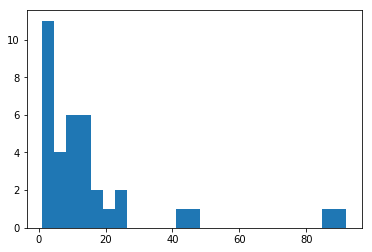

In [10]:
plt.hist(errors, bins=25)

Now, we'll decide (again arbitrarily) to remove subjects from data analysis whose "error" rate was higher than 10% of their total responses.  Since there was a total of 265 stimuli in this study, that cutoff will be 27 or greater.

In [11]:
cutoff = 27  # set the cutoff at 10% of total number of responses (265 x 0.1)
toremove = list(errors[errors >= cutoff].index)
toremove

['Pëjõjân', 'Pëjõkjy', 'Teetwyn', 'Türinpja']

In [12]:
responses = responses[~responses.name.isin(toremove)]
responses.name.unique()

array(['Sêêtâ', 'Pinãprêa', 'Papôj', 'Sââso', 'Mãirã', 'Jôôpyti', 'Kârõ',
       'Kâkwa', 'Sïnëj', 'Pyjõpêj', 'Twatünãjpuu', 'Pêamïrï', 'Passi',
       'Sêêwâ', 'Prïtty', 'Nãnprânprâa', 'Kypakjã', 'Jôtikjã', 'Kjãsi',
       'Tepakriti', 'Kwakjati', 'Kôpyn', 'Sâpôa', 'Pikõ', 'Pâsïrã',
       'Kânkoo', 'Hamãkjya', 'Tutiti', 'Sõnkâti', 'Sôkkrëë', 'Saankôrã',
       'Kassô'], dtype=object)

Now we can further process the response data. We use 1s and 0s to make calculation of proportion responses easy.
1. The RESPONSE column is parsed into three separate columns.  The rationale for spearating the C-response into two columns is to be able to plot separately whether subjects responded with M or P, if it's relevant.
  a. RESPONSE_VNAS: 1 if the response vowel is nasal, 0 if it's oral
  b. RESPONSE_CNAS: 1 if the response consonant contains M, 0 if it doesn't
  c. RESPONSE_CSTOP: 1 if the response consonant contains P, 0 if it doesn't
1. For a more traditional take on the data, we also break the consonant portion of RESPONSE into the three possible responses, RESPONSE_P, RESPONSE_M, and RESPONSE_MP

In [13]:
# separate response columns on locations of consonants and vowels in RESPONSE
responses['response_vnas'] = responses['response'].apply(lambda x: 0 if x[-1]=='a' else 1)
responses['response_cnas'] = responses['response'].apply(lambda x: 1 if x[0]=='m' else 0)
responses['response_cstop'] = responses['response'].apply(lambda x: 1 if x[-2]=='p' else 0)

# separate consonant cluster responses into their own columns as well
responses['response_pav'] = responses['response'].apply(lambda x: 1 if x=='pã' else 0)
responses['response_pa'] = responses['response'].apply(lambda x: 1 if x=='pa' else 0)
responses['response_mav'] = responses['response'].apply(lambda x: 1 if x=='mã' else 0)
responses['response_ma'] = responses['response'].apply(lambda x: 1 if x[:-1]=='mp' else 0)

responses.head()  # preview

,name,item,series,burst,step,response,stimulus,prop_N,response_vnas,response_cnas,response_cstop,response_pav,response_pa,response_mav,response_ma
0,Sêêtâ,1,4,1,7,mã,4.1.7.wav,1.00,1,1,0,0,0,1,0
1,Sêêtâ,2,1,2,4,mpa,1.2.4.wav,0.69,0,1,1,0,0,0,1
2,Sêêtâ,3,3,2,5,mã,3.2.5.wav,1.00,1,1,0,0,0,1,0
3,Sêêtâ,4,4,2,7,mã,4.2.7.wav,1.00,1,1,0,0,0,1,0
4,Sêêtâ,5,4,2,5,mã,4.2.5.wav,0.65,1,1,0,0,0,1,0


Now we'll transform the data by averaging the data over each stimulus (series, burst, and step combination) for each subject.  So for each RESPONSE_X column, each row will contain a given subject's proportion responses with that feature for a given stimulus item.

In [14]:
df_agg = responses.groupby(['name','series','burst','step']).mean().reset_index()
df_agg.head()

,name,series,burst,step,prop_N,response_vnas,response_cnas,response_cstop,response_pav,response_pa,response_mav,response_ma
0,Hamãkjya,1,1,1,0.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,Hamãkjya,1,1,2,0.12,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,Hamãkjya,1,1,3,0.40,0.0,0.2,1.0,0.0,0.8,0.0,0.2
3,Hamãkjya,1,1,4,0.69,0.0,0.6,1.0,0.0,0.4,0.0,0.6
4,Hamãkjya,1,1,5,1.00,0.0,0.8,1.0,0.0,0.2,0.0,0.8


To help us finish processing the data, as well as helping us understand the results, we should remember what the continua are!

Continua 1 & 2 test responses to changing proportions of nasal murmer vs. stop closure duration
Continua 3 & 4 test responses do the same but in the context of a nasal vowel
1. pa~mpa: /pa/ base (most natural context) 
1. pa~mpa: /mã/ base with spliced /a/
3. pã~mpã: continuum 1 with spliced /ã/
4. pã~mpã: continuum 2 with spliced /ã/

Continuum 5 tests responses to varying durations of nasal vs. oral vowel.  Step 1 is fully nasal /ã/ and step 5 is fully oral /a/.  (Continuum 5 has no stop burst.)

First let's look at just series 1-4 in MAINDF.  We'll create these new columns based on the stimulus information at the same time: BURST, BASE, VOWEL.

In [15]:
maindf = df_agg[df_agg.series!='5']  # gather up the subset of the data where SERIES is not 5
maindf['burst'] = maindf['burst'].apply(lambda x: 'yes' if x=='1' else 'no')
maindf['base'] = maindf['series'].apply(lambda x: 'p' if x=='1' or x=='3' else 'm')
maindf['vowel'] = maindf['series'].apply(lambda x: 'oral' if x=='1' or x=='2' else 'nasal')
maindf['totalsteps'] = maindf['series'].apply(lambda x: 4 if x=='1' or x=='3' else 6)  # need this for PROP_STEP
maindf.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,name,series,burst,step,prop_N,response_vnas,response_cnas,response_cstop,response_pav,response_pa,response_mav,response_ma,base,vowel,totalsteps
0,Hamãkjya,1,yes,1,0.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,p,oral,4
1,Hamãkjya,1,yes,2,0.12,0.0,0.0,1.0,0.0,1.0,0.0,0.0,p,oral,4
2,Hamãkjya,1,yes,3,0.40,0.0,0.2,1.0,0.0,0.8,0.0,0.2,p,oral,4
3,Hamãkjya,1,yes,4,0.69,0.0,0.6,1.0,0.0,0.4,0.0,0.6,p,oral,4
4,Hamãkjya,1,yes,5,1.00,0.0,0.8,1.0,0.0,0.2,0.0,0.8,p,oral,4


Now let's plot some stuff!!

First, let's look at vowel nasality responses.  This is mostly to check that the subjects heard the intended vowels.
We'll plot series 1 and 2 (created with oral vowels) on the left, and seires 3 and 4 (created with nasal vowels) on the right.

As we expect, there's a huge difference in responses based on whether the manipulation included a nasal or oral vowel, so that participants responded to series 1 & 2 stimuli with almost no nasal vowel responses, and to series 3 & 4 with almost all nasal vowel responses.  

It is interesting to note that this manipulation worked better in series 3 & 4 than in series 1 & 2.  In particular, it appears that the /mã/ based words are most likely to be heard as having a nasal vowel, although even then it is less than 40% overall.

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

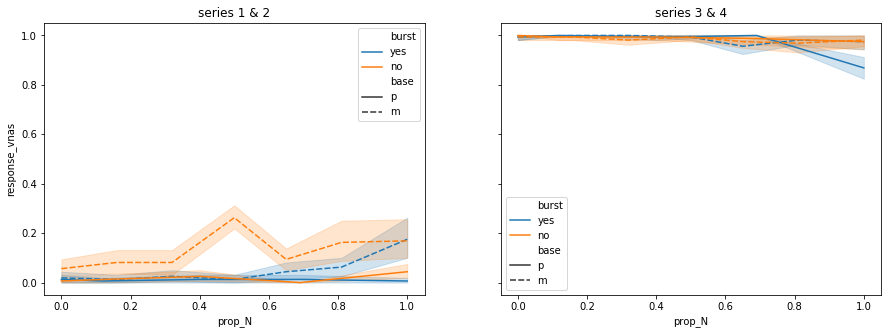

In [16]:
f, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=False, sharey=True)
ax = sns.lineplot(x="prop_N", y="response_vnas", hue='burst', style='base', 
                  data=maindf[(maindf.series=='1') | (maindf.series=='2')],
                  ax=axes[0]).set_title('series 1 & 2')
ax = sns.lineplot(x="prop_N", y="response_vnas", hue='burst', style='base', 
                  data=maindf[(maindf.series=='3') | (maindf.series=='4')],
                  ax=axes[1]).set_title('series 3 & 4')

In [17]:
vnasdf = maindf.groupby(['name','series']).mean().reset_index()
vnasdf.head()

,name,series,prop_N,response_vnas,response_cnas,response_cstop,response_pav,response_pa,response_mav,response_ma,totalsteps
0,Hamãkjya,1,0.442000,0.000000,0.320000,1.000000,0.000000,0.68,0.000000,0.320000,4
1,Hamãkjya,2,0.491429,0.042857,0.500000,0.957143,0.000000,0.50,0.042857,0.457143,6
2,Hamãkjya,3,0.442000,0.980000,0.260000,0.760000,0.740000,0.00,0.240000,0.020000,4
3,Hamãkjya,4,0.491429,1.000000,0.471429,0.528571,0.528571,0.00,0.471429,0.000000,6
4,Jôtikjã,1,0.442000,0.000000,0.420000,1.000000,0.000000,0.58,0.000000,0.420000,4


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


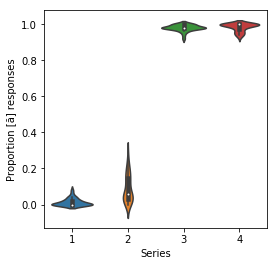

In [18]:
plt.figure(figsize=(4,4))
ax = sns.violinplot(x="series", y="response_vnas", data=vnasdf)
ax.set(ylabel='Proportion [ã] responses', xlabel="Series")
fig = ax.get_figure()
fig.savefig('vnas_response.pdf') 

In [19]:
maindf.head()

,name,series,burst,step,prop_N,response_vnas,response_cnas,response_cstop,response_pav,response_pa,response_mav,response_ma,base,vowel,totalsteps
0,Hamãkjya,1,yes,1,0.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,p,oral,4
1,Hamãkjya,1,yes,2,0.12,0.0,0.0,1.0,0.0,1.0,0.0,0.0,p,oral,4
2,Hamãkjya,1,yes,3,0.40,0.0,0.2,1.0,0.0,0.8,0.0,0.2,p,oral,4
3,Hamãkjya,1,yes,4,0.69,0.0,0.6,1.0,0.0,0.4,0.0,0.6,p,oral,4
4,Hamãkjya,1,yes,5,1.00,0.0,0.8,1.0,0.0,0.2,0.0,0.8,p,oral,4


In [20]:
maindf['response_m']=maindf.response_mav+maindf.response_ma
maindf['response_p']=maindf.response_pav+maindf.response_pa
maindf.base=maindf.base.apply(lambda x: 'mp' if x=='p' else x)
maindf.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

,name,series,burst,step,prop_N,response_vnas,response_cnas,response_cstop,response_pav,response_pa,response_mav,response_ma,base,vowel,totalsteps,response_m,response_p
0,Hamãkjya,1,yes,1,0.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,mp,oral,4,0.0,1.0
1,Hamãkjya,1,yes,2,0.12,0.0,0.0,1.0,0.0,1.0,0.0,0.0,mp,oral,4,0.0,1.0
2,Hamãkjya,1,yes,3,0.40,0.0,0.2,1.0,0.0,0.8,0.0,0.2,mp,oral,4,0.2,0.8
3,Hamãkjya,1,yes,4,0.69,0.0,0.6,1.0,0.0,0.4,0.0,0.6,mp,oral,4,0.6,0.4
4,Hamãkjya,1,yes,5,1.00,0.0,0.8,1.0,0.0,0.2,0.0,0.8,mp,oral,4,0.8,0.2


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


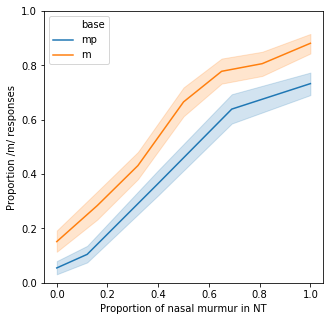

In [21]:
f, axes = plt.subplots(1, 1, figsize=(5, 5))
ax = sns.lineplot(x='prop_N',y='response_m',data=maindf,hue='base')
ax.axes.set(ylabel='Proportion /m/ responses', xlabel="Proportion of nasal murmur in NT",ylim=[0,1])
fig = ax.get_figure()
fig.savefig('M1.pdf') 

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

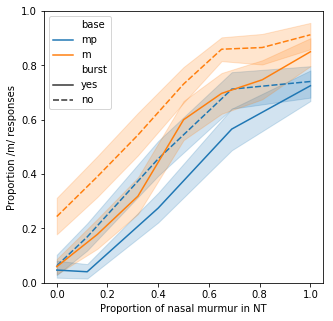

In [22]:
f, axes = plt.subplots(1, 1, figsize=(5, 5))
ax = sns.lineplot(x='prop_N',y='response_m',data=maindf,hue='base',style='burst')
ax.axes.set(ylabel='Proportion /m/ responses', xlabel="Proportion of nasal murmur in NT",ylim=[0,1])
fig = ax.get_figure()
fig.savefig('M2.pdf', bbox_inches='tight') 

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

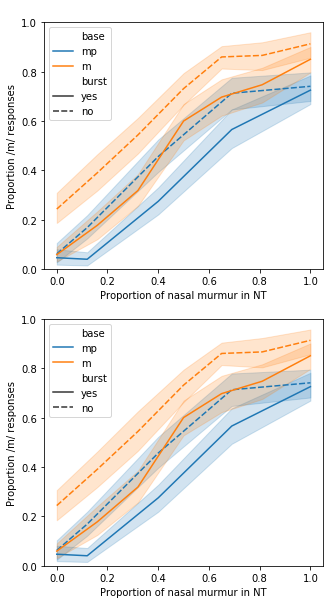

In [23]:
f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=False, sharey=True)
ax = sns.lineplot(x='prop_N',y='response_m',data=maindf,hue='base',style='burst', ax=axes[0]).set_title(' ')
ax = sns.lineplot(x='prop_N',y='response_m',data=maindf,hue='base',style='burst', ax=axes[1]).set_title(' ')
for a in axes.flat:
    a.set(ylabel='Proportion /m/ responses', xlabel="Proportion of nasal murmur in NT", ylim=[0,1])
fig = ax.get_figure()
fig.savefig('M3a.pdf', bbox_inches='tight')

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

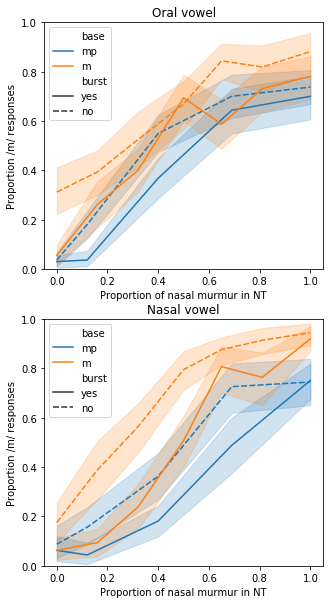

In [24]:
f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=False, sharey=True)
ax = sns.lineplot(x='prop_N',y='response_m',data=maindf[maindf.vowel=='oral'],hue='base',style='burst',
                  ax=axes[0]).set_title('Oral vowel')
ax = sns.lineplot(x='prop_N',y='response_m',data=maindf[maindf.vowel=='nasal'],hue='base',style='burst',
                  ax=axes[1],color=sns.color_palette()[1]).set_title('Nasal vowel')
for a in axes.flat:
    a.set(ylabel='Proportion /m/ responses', xlabel="Proportion of nasal murmur in NT", ylim=[0,1])
fig = ax.get_figure()
fig.savefig('M3.pdf', bbox_inches='tight')

Now let's look at how proprtion of /p/ responses change.  **Note that the x-axis is prop_step, so take care in interpreting differences between base types.**

A few observations:
- Overall, we see that the presence/absence of the stop burst affects listeners' behavior in the predicted direction -- subjects are more likely to respond /p/ when a burst is present -- but the proportion of closure/nasal murmer has a stronger effect.
- Overall, subjects also responded differently based on whether the stimuli were created from a /pa/ or /mã/ base, in the expected direction.  Subjects were less likely to hear a /p/ when the stimuli were created from a /mã/.  This is interesting because it suggests that there is something in the quality of the nasal murmer itself that helps cue listeners too!  

Altogether, we learn that while the proportion of M to P is relevant, it isn't the only factor.

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

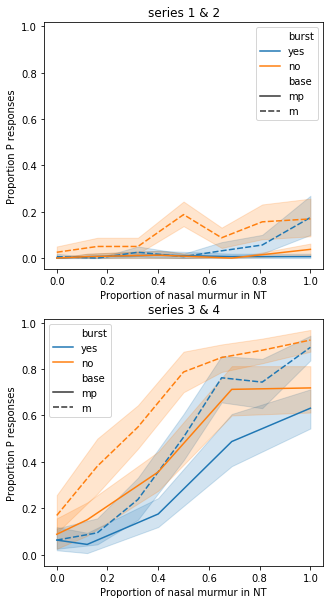

In [25]:
f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=False, sharey=True)
ax = sns.lineplot(x="prop_N", y="response_mav", hue='burst', style='base', data=maindf[maindf.vowel=='oral'],
                  ax=axes[0]).set_title('series 1 & 2')
ax = sns.lineplot(x="prop_N", y="response_mav", hue='burst', style='base', data=maindf[maindf.vowel=='nasal'], 
                  ax=axes[1]).set_title('series 3 & 4')
for a in axes.flat:
    a.set(ylabel='Proportion P responses', xlabel="Proportion of nasal murmur in NT")
    
fig = ax.get_figure()
fig.savefig('NTT_responses.pdf', bbox_inches='tight') 

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

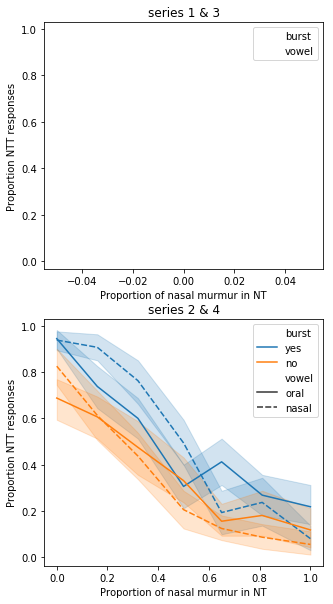

In [26]:
f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=False, sharey=True)
ax = sns.lineplot(x="prop_N", y="response_p", hue='burst', style='vowel', data=maindf[maindf.base=='p'],
                  ax=axes[0]).set_title('series 1 & 3')
ax = sns.lineplot(x="prop_N", y="response_p", hue='burst', style='vowel', data=maindf[maindf.base=='m'], 
                  ax=axes[1]).set_title('series 2 & 4')
for a in axes.flat:
    a.set(ylabel='Proportion NTT responses', xlabel="Proportion of nasal murmur in NT")

fig = ax.get_figure()
fig.savefig('NTT_responses_bybase.pdf') 

In [27]:
t1 = responses.groupby(['name','series','burst','prop_N']).mean()
t2 = t1[['response_ma','response_pa','response_mav','response_pav']].rename(index=str, columns={'response_ma':'ma','response_pa':'pa','response_mav':'mã','response_pav':'pã'})
t2 = t2.stack().reset_index()
t2 = t2.rename(index=str, columns={'level_4':'response',0:'proportion'})
t2.head()

,name,series,burst,prop_N,response,proportion
0,Hamãkjya,1,1,0.0,ma,0.0
1,Hamãkjya,1,1,0.0,pa,1.0
2,Hamãkjya,1,1,0.0,mã,0.0
3,Hamãkjya,1,1,0.0,pã,0.0
4,Hamãkjya,1,1,0.12,ma,0.0


In [28]:
t2.prop_N = pd.to_numeric(t2.prop_N)
t2.dtypes

name           object
series         object
burst          object
prop_N        float64
response       object
proportion    float64
dtype: object

In [29]:
t2['burst'] = t2['burst'].apply(lambda x: 'yes' if x=='1' else 'no')

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

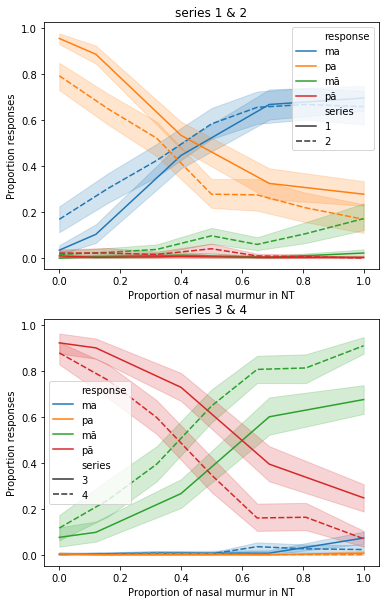

In [30]:
f, axes = plt.subplots(2, 1, figsize=(6, 10), sharex=False, sharey=True)

ax = sns.lineplot(x='prop_N', y='proportion', style='series', hue='response', 
                  data=t2[(t2.series=='1')|(t2.series=='2')], ax=axes[0]).set_title('series 1 & 2')
ax = sns.lineplot(x='prop_N', y='proportion', style='series', hue='response', 
                  data=t2[(t2.series=='3')|(t2.series=='4')], ax=axes[1]).set_title('series 3 & 4')
for a in axes.flat:
    a.set(ylabel='Proportion responses', xlabel="Proportion of nasal murmur in NT")

fig = ax.get_figure()
fig.savefig('NTT_responses_byvowel.pdf', bbox_inches='tight') 

In [31]:
maindf.head()

,name,series,burst,step,prop_N,response_vnas,response_cnas,response_cstop,response_pav,response_pa,response_mav,response_ma,base,vowel,totalsteps,response_m,response_p
0,Hamãkjya,1,yes,1,0.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,mp,oral,4,0.0,1.0
1,Hamãkjya,1,yes,2,0.12,0.0,0.0,1.0,0.0,1.0,0.0,0.0,mp,oral,4,0.0,1.0
2,Hamãkjya,1,yes,3,0.40,0.0,0.2,1.0,0.0,0.8,0.0,0.2,mp,oral,4,0.2,0.8
3,Hamãkjya,1,yes,4,0.69,0.0,0.6,1.0,0.0,0.4,0.0,0.6,mp,oral,4,0.6,0.4
4,Hamãkjya,1,yes,5,1.00,0.0,0.8,1.0,0.0,0.2,0.0,0.8,mp,oral,4,0.8,0.2


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

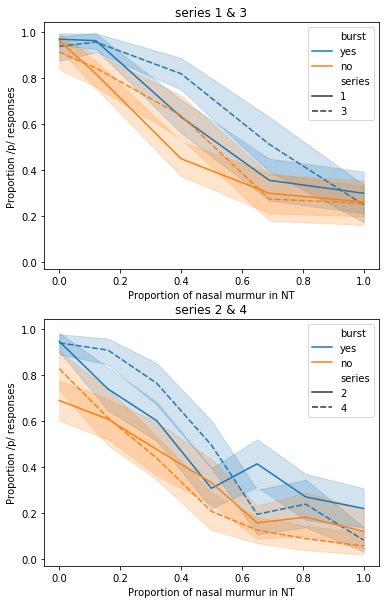

In [32]:
f, axes = plt.subplots(2, 1, figsize=(6, 10), sharex=False, sharey=True)

ax = sns.lineplot(x='prop_N', y='response_p', style='series', hue='burst', 
                  data=maindf[(maindf.series=='1')|(maindf.series=='3')], ax=axes[0]).set_title('series 1 & 3')
ax = sns.lineplot(x='prop_N', y='response_p', style='series', hue='burst', 
                  data=maindf[(maindf.series=='2')|(maindf.series=='4')], ax=axes[1]).set_title('series 2 & 4')
for a in axes.flat:
    a.set(ylabel='Proportion /p/ responses', xlabel="Proportion of nasal murmur in NT")

fig = ax.get_figure()
fig.savefig('T_responses_burst.pdf', bbox_inches='tight') 

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

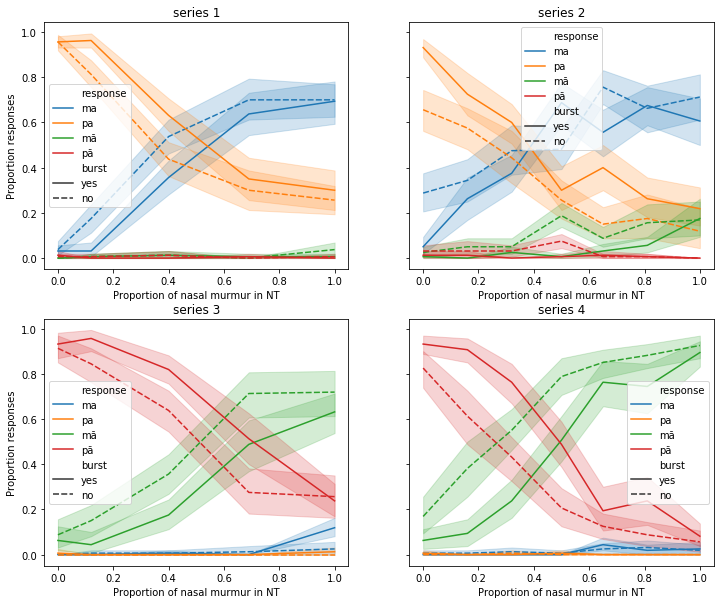

In [33]:
f, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=False, sharey=True)

ax = sns.lineplot(x='prop_N', y='proportion', style='burst', hue='response', 
                  data=t2[(t2.series=='1')], ax=axes[0,0]).set_title('series 1')
ax = sns.lineplot(x='prop_N', y='proportion', style='burst', hue='response', 
                  data=t2[(t2.series=='2')], ax=axes[0,1]).set_title('series 2')
ax = sns.lineplot(x='prop_N', y='proportion', style='burst', hue='response', 
                  data=t2[(t2.series=='3')], ax=axes[1,0]).set_title('series 3')
ax = sns.lineplot(x='prop_N', y='proportion', style='burst', hue='response', 
                  data=t2[(t2.series=='4')], ax=axes[1,1]).set_title('series 4')
for a in axes.flat:
    a.set(ylabel='Proportion responses', xlabel="Proportion of nasal murmur in NT")

fig = ax.get_figure()
fig.savefig('responses_burst.pdf', bbox_inches='tight') 

In [34]:
s12.head()

NameError: name 's12' is not defined

In [35]:
s34 = df_agg[(df_agg.series=='3') | (df_agg.series=='4')]

ax = sns.lineplot(x="step", y="response_m", data=s34, label='m').set_title('series 3 & 4')
ax = sns.lineplot(x="step", y="response_p", data=s34, label='p')
ax = sns.lineplot(x="step", y="response_mp", data=s34, label='mp')
ax.legend()

axes = ax.axes
axes.set_ylim(0,1)

ValueError: Could not interpret input 'response_m'

Now let's look at continuum 5.  First we'll separate the series 5 data from the rest.

In [36]:
nasdf = df_agg[df_agg.series=='5']
nasdf.head()

,name,series,burst,step,prop_N,response_vnas,response_cnas,response_cstop,response_pav,response_pa,response_mav,response_ma
48,Hamãkjya,5,2,1,1.0,0.8,1.0,0.2,0.0,0.0,0.8,0.2
49,Hamãkjya,5,2,2,1.0,0.2,1.0,0.8,0.0,0.0,0.2,0.8
50,Hamãkjya,5,2,3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
51,Hamãkjya,5,2,4,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
52,Hamãkjya,5,2,5,1.0,0.2,1.0,0.8,0.0,0.0,0.2,0.8


Now let's plot the different responses against step.  Looks like people do hear differences based on the duration of vowel nasality, so that they are less likely to hear plain /m/ the more orality is included in the vowel.  Interestingly though, listeners don't flip all the way to hearing /mp/.  Non-/mp/ responses at the "oral" end of the continuum are split roughly equally between /m/ and /p/!  This is kind of odd since there's no very good reason that they should be hearing /pa/.  Probably there are some answers for this mystery if we look at the data split by individual.

In [37]:
ax = sns.lineplot(x="step", y="response_m", data=nasdf, label='m').set_title('series 5')
ax = sns.lineplot(x="step", y="response_p", data=nasdf, label='p')
ax = sns.lineplot(x="step", y="response_mp", data=nasdf, label='mp')
ax.legend()

axes = ax.axes
axes.set_ylim(0,1)

ValueError: Could not interpret input 'response_m'

The data above point to some individual variation.  So let's have a look!

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

KeyboardInterrupt: 

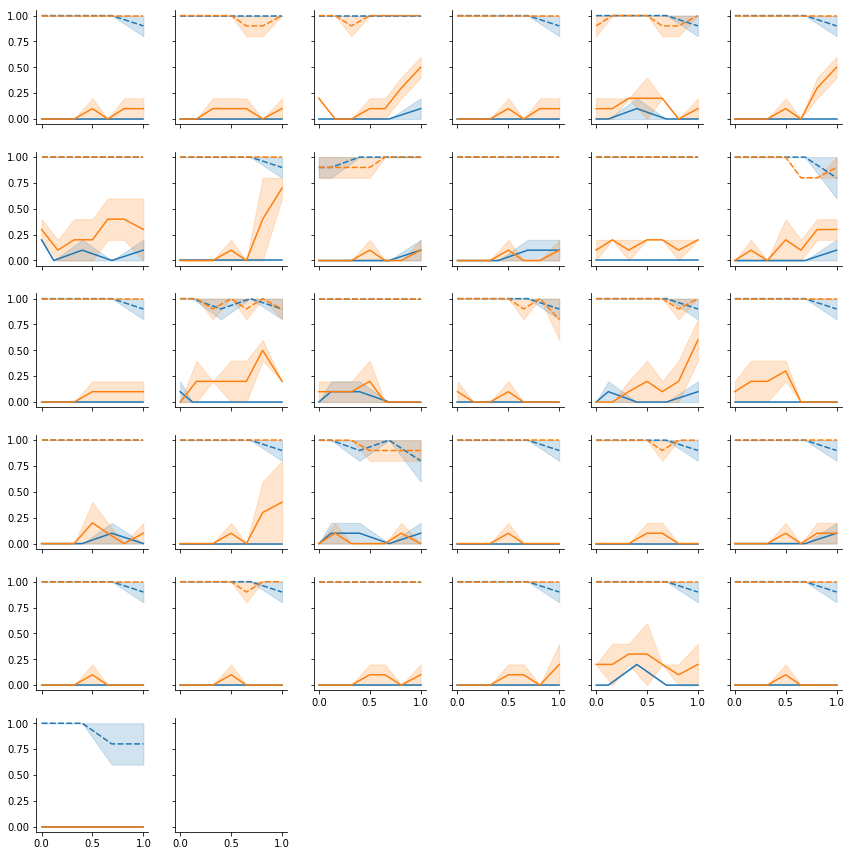

In [38]:
g = sns.FacetGrid(maindf, col="name", col_wrap=6, height=2)
g.map(sns.lineplot, "prop_N", "response_vnas", data=maindf, hue="base", style="vowel")
g.add_legend();

In [ ]:
maindf.head()

In [ ]:
names_order=maindf.groupby(['name']).mean().reset_index().sort_values(by='response_p').name

In [ ]:
names_order

In [39]:
g = sns.FacetGrid(maindf, col="name", col_wrap=8, height=2, col_order=names_order)
g.map(sns.lineplot, "prop_N", "response_m", hue="vowel", style='base',
      data=maindf)
g.add_legend();
g.savefig('allsubjects.pdf', bbox_inches='tight') 

NameError: name 'names_order' is not defined

In [ ]:
g = sns.FacetGrid(t2, col="name", col_wrap=6, height=2)
g.map(sns.lineplot, "prop_N", "proportion", hue="response", style="series",
      data=t2[(t2.series=='1')|(t2.series=='3')])
g.add_legend();

# ax = sns.lineplot(x='prop_N', y='proportion', style='burst', hue='response', 
#                   data=t2[(t2.series=='1')], ax=axes[0,0]).set_title('series 1')

In [ ]:
g = sns.FacetGrid(nasdf, col="name", col_wrap=6, height=2)
g.map(sns.lineplot, "step", "response_m", color='red', label='m')
g.map(sns.lineplot, "step", "response_p", color='blue', label='p')
g.map(sns.lineplot, "step", "response_mp", color='green', label='mp')

g.add_legend();

In [ ]:
responses.to_csv("./response_data.csv")